In [ ]:
#模型选择，过拟合和欠拟合
#训练误差：模型在训练数据集上表现出的误差
#泛化误差：在任意一个测试数据样本上表现出的误差的期望，并常常通过测试数据集上的误差来近似
#一般来说 模型在训练数据集上的表现优于或等于在测试数据集上的表现。机器学习模型应关注降低泛化误差
#模型选择：可供选择的候选模型可以是有着不同超参数的同类模型。
#验证集： 用于模型选择，从训练集中预留一部分训练数据，在完成一个batch后用验证集进行验证。验证集不参与模型训练
#K折交叉验证：把原始训练数据集分割成KK个不重合的子数据集，然后我们做KK次模型训练和验证。
#每一次，我们使用一个子数据集验证模型，并使用其他K−1个子数据集来训练模型。
#最后，我们对这K次训练误差和验证误差分别求平均。
#模型复杂度:模型复杂度较高时训练数据集尽量大


In [1]:
#多项式拟合实验
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("..") 
import d2l.torch as d2l

In [2]:
#数据准备
n_train,n_test,true_w,true_b = 100,100,torch.tensor([[1.2,-3.4,5.6]]),5
featrues = torch.randn((n_train+n_test,1))
poly_features = torch.cat((featrues,torch.pow(featrues,2),torch.pow(featrues,3)),1)
print(poly_features.size())
label = torch.mm(poly_features,true_w.t())+true_b
print(label.size())
label += torch.tensor(np.random.normal(0,0.01,size = label.size()),dtype = torch.float)

torch.Size([200, 3])
torch.Size([200, 1])


In [3]:
#定义、训练和测试模型
num_epochs,loss = 100,torch.nn.MSELoss()
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)
#模型定义
def fit_and_plot(train_features,test_features,train_labels,test_labels):
    ## 通过Linear文档可知，pytorch已经将参数初始化了
    net = torch.nn.Linear(train_features.shape[-1],1)
    print(net)
    batch_size = min(10,train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    data_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    train_ls,test_ls = [],[]
    for epoch in range(num_epochs):
        for X,y in data_iter:
            l = loss(net(X),y.view(-1,1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1,1)
        test_labelst = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features),train_labels).item())
        test_ls.append(loss(net(test_features),test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)
#正常
#fit_and_plot(poly_features[:n_train,:],poly_features[n_train:,:],label[:n_train],label[n_train:])   

Linear(in_features=1, out_features=1, bias=True)
final epoch: train loss 36.5587272644043 test loss 210.1181640625
weight: tensor([[11.5221]]) 
bias: tensor([2.4156])


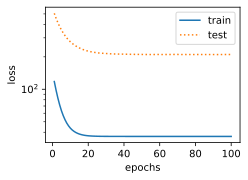

In [7]:
#欠拟合，如果只用线性函数进行拟合，该模型的训练误差在迭代早期下降后便很难继续降低。
fit_and_plot(featrues[:n_train,:],featrues[n_train:,:],label[:n_train],label[n_train:])

Linear(in_features=3, out_features=1, bias=True)
final epoch: train loss 0.0007090193103067577 test loss 313.92333984375
weight: tensor([[2.7259, 1.5883, 1.3140]]) 
bias: tensor([2.6886])


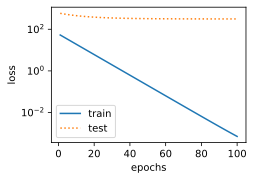

In [6]:
#过拟合，如果训练样本不足，该模型依然容易过拟合。训练样本过少了，甚至少于模型参数的数量。这使模型显得过于复杂，以至于容易被训练数据中的噪声影响。
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], label[0:2],
             label[n_train:])